<h1 style="text-align: center;">Stable Diffusion v2.1 using Optimum-Intel OpenVINO</h1>
<img src="https://github.com/openvinotoolkit/openvino_notebooks/assets/10940214/1858dae4-72fd-401e-b055-66d503d82446"  width="30%" height="30%">


Optimum Intel is the interface between the Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures. More details in this [repository](https://github.com/huggingface/optimum-intel#openvino). 

`Note: We suggest you to create a different environment and run the following installation command there.`

In [ ]:
%pip install -q "optimum-intel[openvino,diffusers]" "ipywidgets"

Stable Diffusion pipeline should brings 6 elements together, a text encoder model with a tokenizer, a UNet model with and scheduler, and an Autoencoder with Decoder and Encoder models. 

![image](https://github.com/openvinotoolkit/openvino_notebooks/assets/10940214/e166f225-1220-44aa-a987-84471e03947d)


The base model used for this example is the "[stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1). This model was converted to OpenVINO format, for accelerated inference on CPU or Intel GPU with OpenVINO's integration into Optimum: optimum-intel. The model weights are stored with FP16 precision, which reduces the size of the model by half. You can find the model used in this notebook is "[helenai/stabilityai-stable-diffusion-2-1-base-ov](https://huggingface.co/helenai/stabilityai-stable-diffusion-2-1-base-ov)". Let's download the pre-converted model Stable Diffusion 2.1 [Intermediate Representation Format (IR)](https://docs.openvino.ai/2022.3/openvino_docs_MO_DG_IR_and_opsets.html)

### Showing Info Available Devices

The `available_devices` property shows the available devices in your system. The "FULL_DEVICE_NAME" option to `ie.get_property()` shows the name of the device. Check what is the ID name for the discrete GPU, if you have integrated GPU (iGPU) and discrete GPU (dGPU), it will show `device_name="GPU.0"` for iGPU and `device_name="GPU.1"` for dGPU. If you just have either an iGPU or dGPU that will be assigned to `"GPU"`

Note: For more details about GPU with OpenVINO visit this [link](https://docs.openvino.ai/nightly/openvino_docs_install_guides_configurations_for_intel_gpu.html). If you have been facing any issue in Ubuntu 20.04 or Windows 11 read this [blog](https://blog.openvino.ai/blog-posts/install-gpu-drivers-windows-ubuntu).

In [1]:
from openvino.runtime import Core

ie = Core()
devices = ie.available_devices

for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) i7-10710U CPU @ 1.10GHz
GPU: Intel(R) UHD Graphics [0x9bca] (iGPU)


### Download Pre-Converted Stable Diffusion 2.1 IR 

In [2]:
from optimum.intel.openvino import OVStableDiffusionPipeline
# download the pre-converted SD v2.1 model from Hugging Face Hub
name = "helenai/stabilityai-stable-diffusion-2-1-base-ov"

pipe = OVStableDiffusionPipeline.from_pretrained(name, compile=False)
pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)

2023-06-28 22:32:41.013254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 22:32:41.058009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 22:32:41.058942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 22:32:41.898413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


The config attributes {'requires_safety_checker': False, 'safety_checker': [None, None]} were passed to OVStableDiffusionPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/apulache/mambaforge/envs/openVino/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


OVStableDiffusionPipeline {
  "_class_name": "OVStableDiffusionPipeline",
  "_diffusers_version": "0.17.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "optimum",
    "OVModelTextEncoder"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "optimum",
    "OVModelUnet"
  ],
  "vae_decoder": [
    "optimum",
    "OVModelVaeDecoder"
  ],
  "vae_encoder": [
    null,
    null
  ]
}

### Save the pre-trained models, Select the inference device and compile it

You can save the model locally in order to avoid downloading process later. The model will also saved in the cache.

In [3]:
# pipe.save_pretrained("./openvino_ir") # Uncomment if you need the model for further compilations
pipe.to("GPU")
pipe.compile()

Compiling the text_encoder...
Compiling the vae_decoder...
Compiling the unet...


### Be creative, add the prompt and enjoy the result

  0%|          | 0/18 [00:00<?, ?it/s]

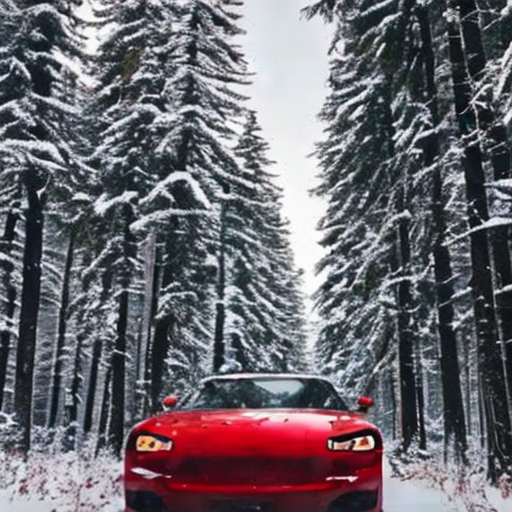

In [5]:
# Generate an image. 
prompt = "red car in snowy forest, epic vista, beautiful landscape, 4k, 8k"
output = pipe(prompt, num_inference_steps=17, output_type="pil").images[0]
output.save("image.png")
output